Similarly, if you want to see view counts on your Kaggle notebooks - you have to increase the view count by one... *until now!* We can spy on the latest view counts (and other stats) by requesting a listing from the Kaggle API...

To use this notebook:

 1.   Fork this notebook by clicking on Copy and Edit.
 2.   Set the username variable to your own username.

In [1]:
username = 'azminetoushikwasi'

In [2]:
from IPython.display import Markdown, display
import datetime, requests, json, os, re, sys, time
from matplotlib.ticker import FixedLocator, MaxNLocator
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 500)

session = requests.session()
profile = session.get('https://www.kaggle.com/' + username)
session.headers['x-xsrf-token'] = session.cookies['XSRF-TOKEN']

uid = int(re.findall('Kaggle\.State\.push\({.*?"userId":(\d+),', profile.text)[0])
count = int(re.findall('"scriptsSummary":{.*?"totalResults":(\d+),', profile.text)[0])
pages = int(np.ceil(count / 20))

In [4]:
url = 'https://www.kaggle.com/api/i/kernels.KernelsService/ListKernels'
request = {
    'kernelFilterCriteria': {
        'search': '',
        'listRequest': {
            'userId': 0,
            'sortBy': 'DATE_RUN',
            'pageSize': 20,
            'group': 'PROFILE',
            'page': 1,
            'tagIds': '',
            'excludeResultsFilesOutputs': False,
            'wantOutputFiles': False
        }
    },
    'detailFilterCriteria': {
        'deletedAccessBehavior': 'RETURN_NOTHING',
        'unauthorizedAccessBehavior': 'RETURN_NOTHING',
        'excludeResultsFilesOutputs': False,
        'wantOutputFiles': False,
        'kernelIds': [],
        'outputFileTypes': []
    }
}

In [5]:
request['kernelFilterCriteria']['listRequest']['userId'] = uid

dfs = []
for page in range(1, pages + 1):
    request['kernelFilterCriteria']['listRequest']['page'] = page
    data = json.dumps(request, separators=(',', ':'))
    res = session.post(url, data=data)
    #print(page, res.status_code, len(res.text))
    if res.status_code != 200:
        break
    df = pd.DataFrame(json.loads(res.text)['kernels'])
    dfs.append(df)

def split_columns(df, col):
    values = df.pop(col)
    return df.join(values.apply(pd.Series).add_prefix(col + "_"))

df = pd.concat(dfs, ignore_index=True)
df = split_columns(df, 'author')
df = split_columns(df, 'dataSources')
df = split_columns(df, 'categories')

filename = f'{username}-{datetime.datetime.now().strftime("%Y-%m-%d")}.csv'
df.to_csv("./data/"+filename, index=False)

display(Markdown(f"""
 - Notebook count: {df.shape[0]:,.0f}
 - Total views: {df.totalViews.sum():,.0f}
 - Total comments: {df.totalComments.sum():,.0f}
 - Total medals: {df.medal.count():,.0f}
 - Total votes: {df.totalVotes.sum():,.0f}
 - Mean views per vote: {df.totalViews.sum() / df.totalVotes.sum():,.0f}
"""))


 - Notebook count: 13
 - Total views: 23,922
 - Total comments: 269
 - Total medals: 13
 - Total votes: 890
 - Mean views per vote: 27


In [6]:
display(Markdown(f'# Notebooks by {df.author_displayName.get(0)}'))
df['viewsPerVote'] = df.eval('(totalViews+1)/(totalVotes+1)')
df['lastRun'] = pd.to_datetime(df.lastRunTime).dt.strftime('%c')
stats = ['totalViews', 'totalVotes', 'totalLines', 'totalComments']
links = ('<a href="https://www.kaggle.com' + df.scriptUrl + '" '
         + ' title="'
         + 'Language: ' + df.languageName.fillna('N/A') + '\n'
         + 'Medal: ' + df.medal.fillna('N/A') + '\n'
         + 'Last run: ' + df.lastRun + '\n'
         + 'Runtime: ' + df.lastRunExecutionTimeSeconds.map(str) + 's' + '\n'
         + 'Views per vote: ' + df.eval('(totalViews+1)/(totalVotes+1)').apply(lambda x: f'{x:,.0f}')
         + '">' # end title="..."
         + df.title
         + '</a>')
show = df[['title'] + stats].copy()
show['title'] = links
show.style.format({k:'{:,.0f}' for k in stats}, na_rep="").hide_index().bar(width=50, color='#4cf')

# Notebooks by Azmine Toushik Wasi

title,totalViews,totalVotes,totalLines,totalComments
Daily AQI - Air Quality Index [Scheduled],460,23,435,7
Classification ➡️ Comparing Different Algorithms,168,17,324,1
"▶️ Cristiano Ronaldo ⚽ Goals 📊 EDA, Analysis","2,210",60,306,33
"Coursera 📉 EDA, Insights, Sentiment Analysis",663,37,414,18
ML Foundation ➡️ Feature Engineering,"1,648",52,382,18
Investment and Financial Analysis 🏭 GeoExports,762,41,461,16
UCL ⚽ EDA & Viz ⭐ 2021-22 ⭐ Players & Teams,"2,021",67,536,26
ML Foundation ➡️ Bias-Variance Tradeoff,"2,950",84,592,30
Divorce Prediction & Reasons Analysis with PCA,"1,348",57,608,20
▶️ Lionel Messi 📊 Extended EDA ⚽ Goals,"2,225",75,380,31


In [7]:
df['medal'].fillna('N/A', inplace=True)
medal_data=df[['medal','title']].set_index('title')
medal_data=medal_data.to_dict(orient='index')

# Plotly Scatter Plot

You may want to tweak these settings depending on how many notebooks you have...


In [8]:
import plotly.express as px
from datetime import datetime


df['totalComments'].fillna(0, inplace=True)
df['medal'].fillna('N/A', inplace=True)
df['size'] = df['totalComments'].clip(lower=1)
color_map = {
    'GOLD': 'gold',
    'SILVER': 'silver',
    'BRONZE': 'chocolate',
    'N/A': '#333'
}
px.scatter(
    df,
    'totalViews',
    'totalVotes',
    title=f'Notebooks by {df.author_displayName.get(0)} Today '+str(datetime.today().strftime('%Y-%m-%d')),
    log_x=False,
    log_y=False,
    #width=800, 
    height=600,
    color='medal',
    color_discrete_map=color_map,
    size='size',
    trendline='ols',
    trendline_options=dict(log_x=False, log_y=False, add_constant=True),
    #trendline='lowess', # Use for Locally Weighted Scatterplot Smoothing line
    #trendline_scope='overall', # Use this for one trendline
    hover_name='title',
    hover_data={
        'size': False,
        'totalViews': ':,.0f',
        'totalVotes': ':,.0f',
        'totalLines': ':,.0f',
        'totalComments': ':,.0f',
        'viewsPerVote': ':,.0f',
        'languageName': True,
        'versionNumber': True,
        'lastRun': True,
        'lastRunExecutionTimeSeconds': ':,.0f',
        'medal': True,
    })

In [9]:
links=[]
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        link=os.path.join(dirname, filename)
        if filename.endswith(".csv"):
            links.append(link)

In [10]:
dft=pd.read_csv(links[-2])

dft['totalComments'].fillna(0, inplace=True)
dft['medal'].fillna('N/A', inplace=True)
dft['size'] = dft['totalComments'].clip(lower=1)
color_map = {
    'GOLD': 'gold',
    'SILVER': 'silver',
    'BRONZE': 'chocolate',
    'N/A': '#333'}
px.scatter(
    dft,
    'totalViews',
    'totalVotes',
    title=f'Notebooks by {df.author_displayName.get(0)} '+str(links[-2][25:35]),
    log_x=False,
    log_y=False,
    #width=800, 
    height=500,
    color='medal',
    color_discrete_map=color_map,
    size='size',
    trendline='ols',
    trendline_options=dict(log_x=False, log_y=False, add_constant=True),
    #trendline='lowess', # Use for Locally Weighted Scatterplot Smoothing line
    #trendline_scope='overall', # Use this for one trendline
    hover_name='title')

# Analysis

In [11]:
dfx=pd.DataFrame()
date_list=[]
titles_dft=[]
date_dft=[]
count_dft=[]
view_dft=[]

gTotalUpvotes=[]
gTotalViews=[]
gTotalComments=[]


for link in links:
    date=link[25:35]
    date_list.append(date)
    temp_df=pd.read_csv(link)
    
    gTotalUpvotes.append(temp_df.totalVotes.sum())
    gTotalViews.append(temp_df.totalViews.sum())
    gTotalComments.append(temp_df.totalComments.sum())
    
    temp_titles=list(temp_df.title)
    temp_totalVotes=list(temp_df.totalVotes)
    temp_totalViews=list(temp_df.totalViews)
    
    for name in temp_titles:
        titles_dft.append(name)
        date_dft.append(date)
        count_dft.append(temp_totalVotes[temp_titles.index(name)])
        view_dft.append(temp_totalViews[temp_titles.index(name)])


df_d={"title":titles_dft, "date":date_dft, "count":count_dft,"view_count":view_dft}
df_d=pd.DataFrame(df_d)


In [12]:
medal=[]
for i in range(len(df_d)):
    medal.append(medal_data[df_d['title'][i]]['medal'])
df_d['medal']=medal

In [13]:
"""sns.set(rc={'figure.figsize':(28,20)})

p=sns.lineplot(x='date',data=df_d,y='count',style='title',palette='Dark2',hue="medal",markers=True,markersize=15)
plt.xticks(fontsize=10,rotation='vertical')
p.axes.axhline(y=7,linewidth =5, color='brown',alpha=0.5)
p.axes.axhline(y=25,linewidth =5, color='silver',alpha=0.5)
p.axes.axhline(y=60,linewidth =5, color='gold',alpha=0.5)
p.axes.set_title("\nUpvotes\n",fontsize=20);
for l in p.lines:
    y = l.get_ydata()
    if len(y)>0:
        p.annotate(f'{y[-1]:.0f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color())
plt.legend(fontsize='x-large', title_fontsize='40',markerscale=2)
plt.show();""";

In [14]:
px.line(
    df_d,
    x='date',
    y='count',
    title=f'Notebooks by {df.author_displayName.get(0)} '+str(links[-2][25:35]),
    log_x=False,
    log_y=False,
    symbol='title',
    markers=True,
    #width=800, 
    height=800,
    color='medal',
    hover_name='title')

In [15]:
"""sns.set(rc={'figure.figsize':(28,20)})
p=sns.lineplot(x='date',data=df_d,y='view_count',style='title',palette='Dark2',hue="medal",markers=True,markersize=15)
plt.xticks(fontsize=10,rotation='vertical')
p.axes.set_title("\nViews\n",fontsize=20)
p.axes.axhline(y=2000, linewidth =4, color='brown',alpha=0.3,linestyle='--')
p.axes.axhline(y=3000, linewidth =4, color='red',alpha=0.3,linestyle='--')
p.axes.axhline(y=4000, linewidth =4, color='red',alpha=0.3,linestyle='--');
for l in p.lines:
    y = l.get_ydata()
    if len(y)>0:
        p.annotate(f'{y[-1]:.0f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color())
plt.legend(fontsize='x-large', title_fontsize='40',markerscale=2)
plt.show();""";

In [16]:
px.line(
    df_d,
    x='date',
    y='view_count',
    title=f'Notebooks by {df.author_displayName.get(0)} '+str(links[-2][25:35]),
    log_x=False,
    log_y=False,
    symbol='title',
    markers=True,
    #width=800, 
    height=800,
    color='medal',
    hover_name='title')

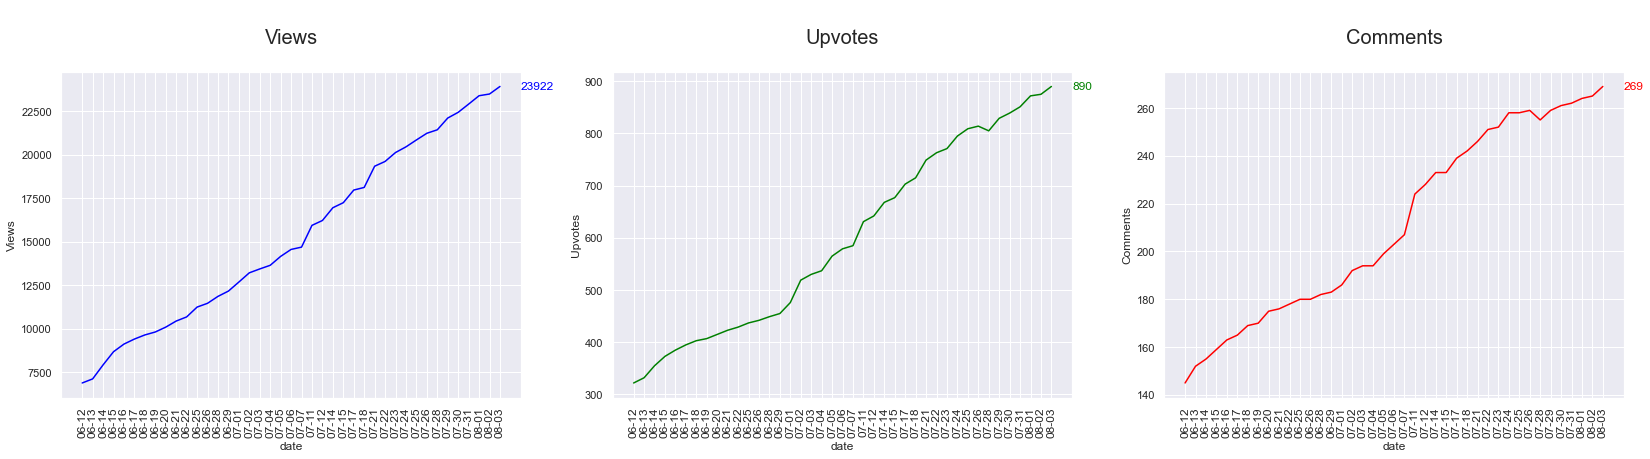

In [17]:
totals={'date':date_list,"Upvotes":gTotalUpvotes,"Views":gTotalViews,"Comments":gTotalComments}
totals=pd.DataFrame(totals)
totals['date']=totals['date'].str[5:]


sns.set(rc={'figure.figsize':(28,6)})

plt.subplot(1,3,1)
#p=sns.barplot(x='date',data=totals,y='Views',color='lightgrey')
#p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-40,rotation='vertical')
p=sns.lineplot(x='date',data=totals,y="Views",color='blue')
plt.xticks(fontsize=12,rotation='vertical')
for l in p.lines:
    y = l.get_ydata()
    if len(y)>0:
        p.annotate(f'{y[-1]:.0f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color())

p.axes.set_title("\nViews\n",fontsize=20);


plt.subplot(1,3,2)
#p=sns.barplot(x='date',data=totals,y='Upvotes',color='lightgrey')
#p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-40,rotation='vertical')
p=sns.lineplot(x='date',data=totals,y="Upvotes",color='green')
plt.xticks(fontsize=12,rotation='vertical')
for l in p.lines:
    y = l.get_ydata()
    if len(y)>0:
        p.annotate(f'{y[-1]:.0f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color())

p.axes.set_title("\nUpvotes\n",fontsize=20);

plt.subplot(1,3,3)
#p=sns.barplot(x='date',data=totals,y='Comments',color='lightgrey')
#p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-40,rotation='vertical')
p=sns.lineplot(x='date',data=totals,y="Comments",color='red')
plt.xticks(fontsize=12,rotation='vertical');
for l in p.lines:
    y = l.get_ydata()
    if len(y)>0:
        p.annotate(f'{y[-1]:.0f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color())

p.axes.set_title("\nComments\n",fontsize=20);

In [18]:
df_d.title.unique()

array(['UCL ⚽ EDA & Viz ⭐ 2021-22 ⭐ Players & Teams',
       'Divorce Prediction & Reasons Analysis with PCA',
       'ML Foundation ➡️ Feature Engineering',
       'ML Foundation ➡️ Imputation : All Techniques',
       'ML Foundation ➡️ Bias-Variance Tradeoff ',
       '▶️ Lionel Messi 📊 Extended EDA ⚽ Goals ',
       '▶️ Cristiano Ronaldo ⚽ Goals  📊 EDA, Analysis',
       'Coursera 📉 EDA, Insights, Sentiment Analysis',
       'Investment and Financial Analysis  🏭 GeoExports',
       'ML Foundation ➡️ Cross Validation ✅ All Methods',
       'ML Foundation ➡️ Clustering Techniques, Algorithms',
       'Daily AQI - Air Quality Index [Scheduled]',
       'Classification ➡️ Comparing Different Algorithms'], dtype=object)